### Neuro-Traces
- This demo will show how to analysis neuro trace of response in vector space, which is very popular these days.    

This method will plot neuro response through time, making it possible for state transform.    
We will provide : 
1. PCA-UMAP method of dim reduction
2. Graph based method trace plotting

In [1]:
# load in
#%%
import Common_Functions as cf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tqdm import tqdm
import pandas as pd
from Brain_Atlas.Atlas_Mask import Mask_Generator
from Signal_Functions.Pattern_Tools import Do_PCA
import seaborn as sns
import umap
import copy
  
wp = r'D:\ZR\_Data_Temp\Ois200_Data\Full_Demo\Wild_Type\Preprocessed'
MG = Mask_Generator(bin=4)

# load 1D vector for further analysis.
on_response,on_mask = cf.Load_Variable(wp,'Response_1d.pkl')


#### kill cache first. If kernel dead, you will need this.
# NOTE this step will lead to a cost of time, so avoid using it unless you have to.
cf.Kill_Cache(root_folder=r'C:\ProgramData\anaconda3\envs\Lulab_OI_Env')

Total 3367 cache folder killed.


___
- ##### Part1, PCA-UMAP dimension reduction.
Use PCA to denoise the data, then use UMAP transfer it into 2D.    
Then you will see as time goes by, how will the state of response change.

PCA denoise first.    
As used before, PCA functio is already packed.

 Top 50 PC explains, 99.83% VARs
(18025, 1574)


<AxesSubplot: >

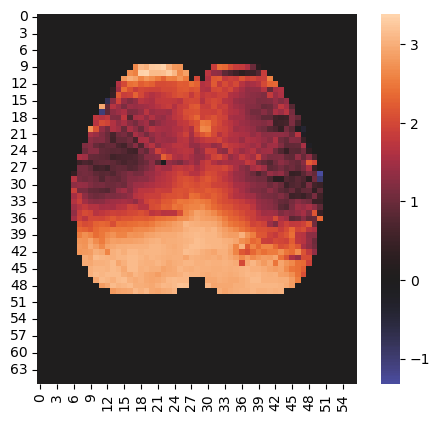

In [2]:
PC_Comp_raw,coords_raw,model_raw = Do_PCA(on_response,feature='Area',pcnum=50) # keep on first 50 PCs.
explained_var = model_raw.explained_variance_ratio_.sum()
print(f' Top 50 PC explains, {explained_var*100:.2f}% VARs')

# then recover pc series just by dot mutiply.
recovered_series = np.dot(coords_raw,PC_Comp_raw)
# NOTE the shape is different!
print(recovered_series.shape)

# then you can check recovered graph, almost unchanged.
recover = copy.deepcopy(on_mask).astype('f8')
recover[recover==True] = recovered_series[6454,:]
sns.heatmap(recover,square=True,center=0)

- Then, do UMAP on already dim-reduced data.    
UMAP is an easy package for dim reduction, it have lots of pros and cons.    

Check https://umap-learn.readthedocs.io/en/latest/index.html for detail.    

Remember that UMAP is a randomrized method, if you want to completely repeat the result, please set random seed or just save reducer directly.

In [4]:
#### declare usage of umap.
reducer = umap.UMAP(n_components=3,n_neighbors=300,min_dist=0.02)
# n_components: number of dims after supression
# n_neighbor: num of neighbors used while building graph
# min_dist: min dist of elements for visualization
# there are more paras not shown, read the doc.

#### After declare, fit the model.
# NOTE the matrix shall be in shape N_Sample*N_Feature
reducer.fit(recovered_series)

#### Show points after reduction.
u = reducer.transform(recovered_series)
print(f'UMAP supressed data have shape {u.shape}')

# save reducer if you want to
cf.Save_Variable(wp,'UMAP_Reducer',reducer)

UMAP supressed data have shape (18025, 3)


True

Plot UMAP graph will show trace of neuro response.    
We plot a small part of trace, the pattern here can be more clear.

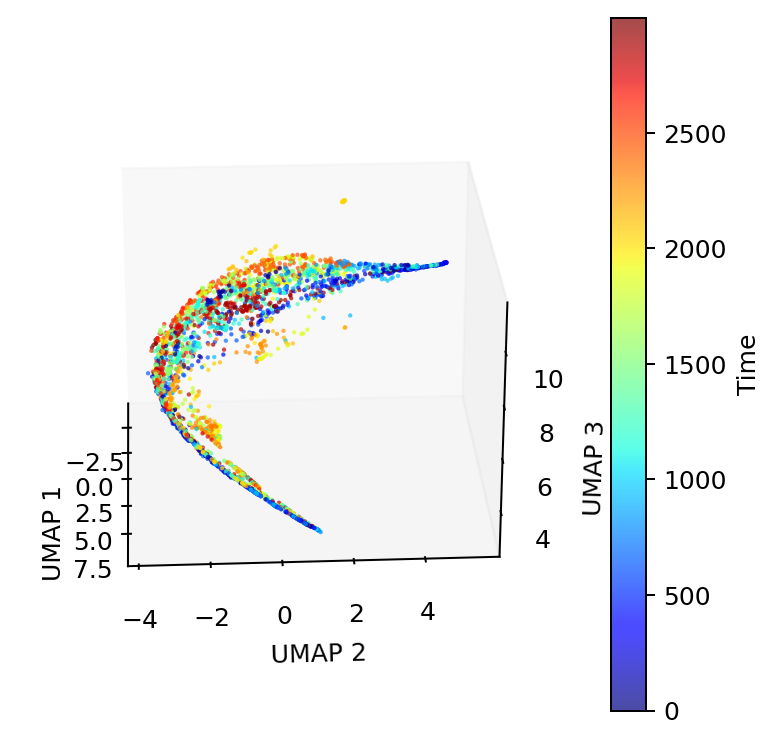

In [7]:
from matplotlib.animation import FuncAnimation
from PIL import Image  # For GIF processing

plotable = u[10000:13000,:] # plot only 3000 points, about 600s

fig, ax = plt.subplots(nrows=1, ncols=1, subplot_kw={'projection': '3d'},figsize = (5,5),dpi = 180)
ax.grid(False)
scatter = ax.scatter(plotable[:,0],plotable[:,1],plotable[:,2],c=range(len(plotable)), cmap='jet', alpha=0.7,edgecolors='none',s=3)

plt.colorbar(scatter, label='Time')
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
ax.set_zlabel('UMAP 3')



## Codes below will make gif
n_frames = 120  
azim_step = 3 
elevation = 25  # Fixed elevation angle
def update(frame):
    """Update function for each animation frame"""
    ax.view_init(elev=elevation, azim=frame*azim_step)
    return scatter,

ani = FuncAnimation(fig, 
                   update, 
                   frames=n_frames,
                   blit=True,
                   interval=50)
# Save as GIF
ani.save(cf.join(wp,'UMAP_Traces.gif'), 
        writer='pillow', 
        fps=12,  # Adjust for rotation speed
        dpi=180)

- 👆 As you can see, different time have different time trace.
___

- ##### Part2, Graph Based Trace method.    
Graph method has a problem: as the graph is built inside, so you cannot cut it after building.

<AxesSubplot: >

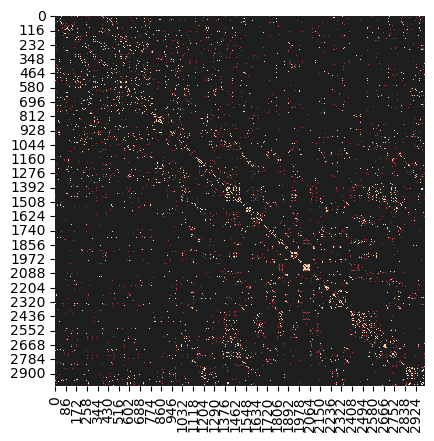

In [46]:
# build graph.
from sklearn.neighbors import kneighbors_graph
import networkx as nx
kn = 80

normalized_ts = (on_response - on_response.mean(axis=1, keepdims=True))/on_response.std(axis=1, keepdims=True)
normalized_ts = normalized_ts.T
normalized_ts = normalized_ts[10000:13000,:]

# adjacency matrix of time seires.
adjacency = kneighbors_graph(normalized_ts,n_neighbors=kn,mode='connectivity',metric='l2',include_self=False)
adjacency = (adjacency+adjacency.T)/2 
# plot graph
sns.heatmap(adjacency.toarray(),center=0,vmax = 1,cbar=False,square=True)

As you can see, connection matrix is a lot different from spacial graph, but there seems to have pattern inside.    
Big graph is harder to visualize, so you need to be creative for visualization.

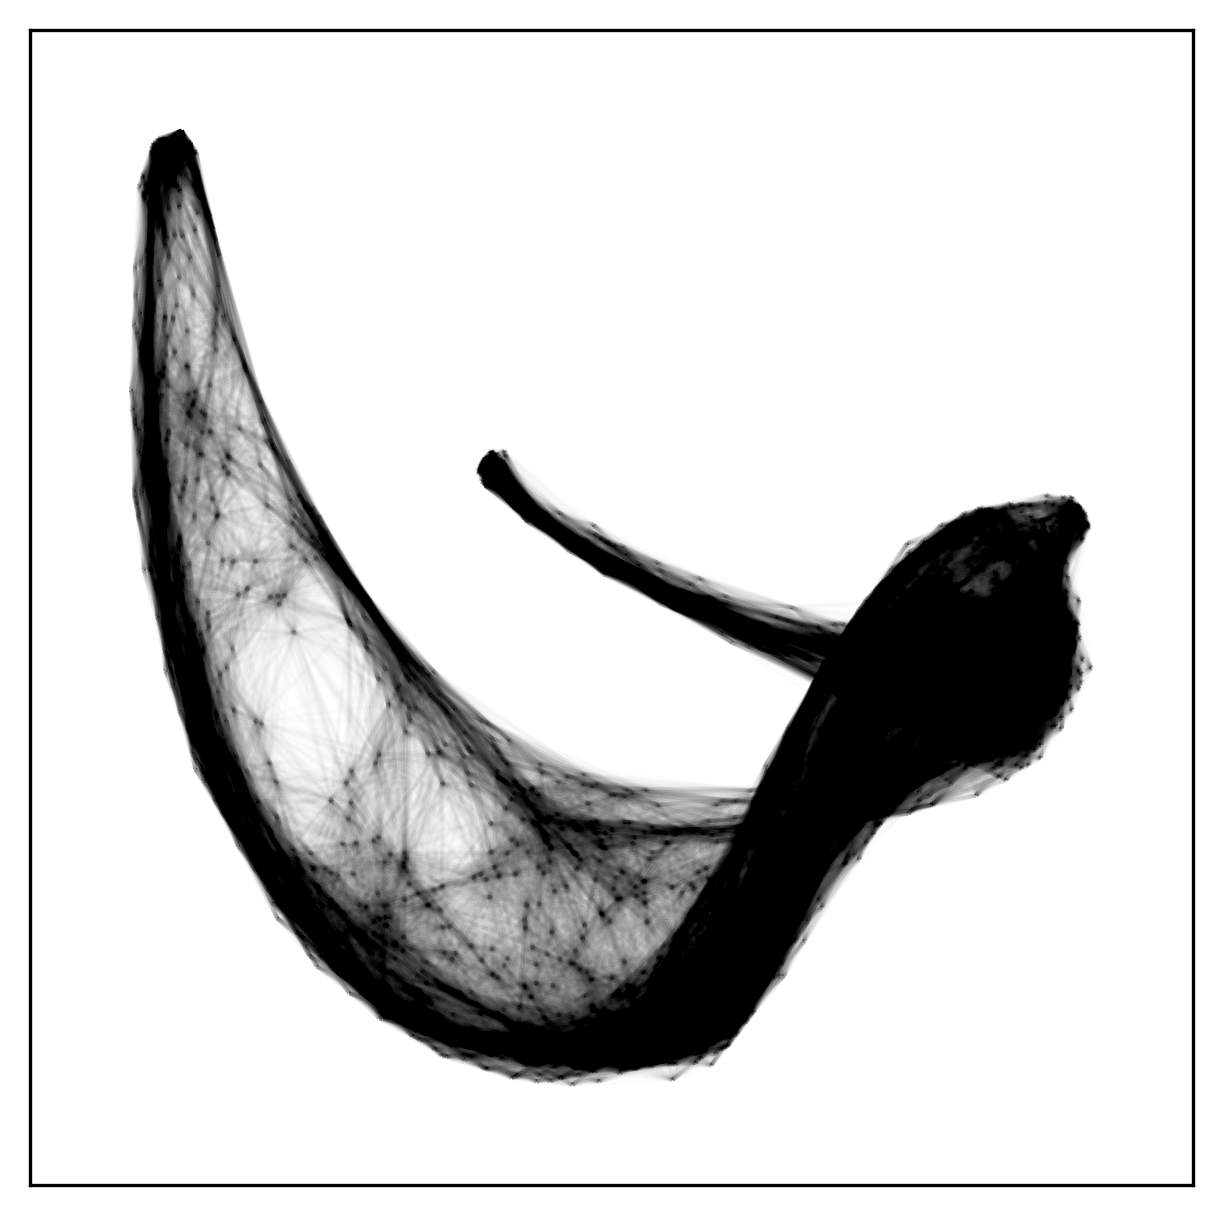

In [47]:
# Visualization of graph
# Nodes are too much for good visualization.

# generate graph and visualize position
G = nx.from_scipy_sparse_array(adjacency)
pos = nx.spring_layout(G,seed=1023)

# plot nodes here
fig,ax = plt.subplots(ncols=1,nrows=1,figsize = (5,5),dpi = 300)
nx.draw_networkx_edges(G, pos, alpha=0.01,ax = ax)


Graph is too big to find visable pattern, you might need to think about how to deal with it...    

But you can still find time-connected pattern on graph, which indicate state change.

<AxesSubplot: xlabel='X', ylabel='Y'>

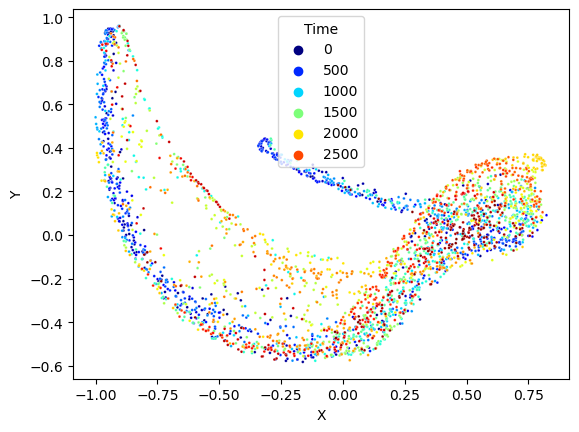

In [50]:
# plot times on graph
pos_frame = pd.DataFrame({'Time':pos.keys(),'X':np.array(list(pos.values()))[:,0],'Y':np.array(list(pos.values()))[:,1]})
# pos_frame = pos
sns.scatterplot(data=pos_frame,x = 'X',y='Y',hue='Time',palette=plt.cm.jet,s=4,lw=0)


👆 Two boulders might indicate on and off state, and different curve will cause a systematic connection preference.    
Maybe for higher kn and more point will release more info, you can try it by your self.